In [1]:
using Pkg
Pkg.activate("..")

  Activating project at `~/.julia/dev/ProactiveHRI`


In [2]:
using Interpolations
using MAT
using StaticArrays
using Parameters
using JuMP, HiGHS, ECOS


In [3]:
include("dynamics.jl")
include("planner.jl")
include("planner_utils.jl")
include("utils.jl")
include("plotting.jl")
include("sim.jl")

simulate_human_social_forces (generic function with 1 method)

In [201]:
include("velocity_obstacles.jl")

reactive_velocity_obstacles (generic function with 1 method)

In [325]:
# HJIdata = matread("../hj_cache/DynamicallyExtendedUnicycle_VO_40_40_10_12_12.mat")
HJIdata = matread("../hj_cache/DynamicallyExtendedUnicycle_VO_50_50_10_20_20.mat")

V_mat = HJIdata["V"]
V_mat = [V_mat;;;V_mat[:,:,1:1,:,:]]
grid_knots = tuple((x -> convert(Vector{Float32}, vec(x))).(HJIdata["grid_knots"])...)
push!(grid_knots[3], -grid_knots[3][1])
V  = interpolate(Float32, Float32, grid_knots, V_mat, Gridded(Linear()));
# grid = HJIdata["grid"];

50×50×11×20×20 interpolate((::Vector{Float32},::Vector{Float32},::Vector{Float32},::Vector{Float32},::Vector{Float32}), ::Array{Float32, 5}, Gridded(Linear())) with element type Float32:
[:, :, 1, 1, 1] =
 -1.21421   -1.18565   -1.15772   …  -1.15772   -1.18565   -1.21421
 -1.18565   -1.15649   -1.12794      -1.12794   -1.15649   -1.18565
 -1.15772   -1.12794   -1.09877      -1.09877   -1.12794   -1.15772
 -1.13045   -1.10005   -1.07023      -1.07023   -1.10005   -1.13045
 -1.10389   -1.07285   -1.04239      -1.04239   -1.07285   -1.10389
 -1.07808   -1.0464    -1.01527   …  -1.01527   -1.0464    -1.07808
 -1.05307   -1.02074   -0.98894      -0.98894   -1.02074   -1.05307
 -1.0289    -0.995925  -0.963444     -0.963444  -0.995925  -1.0289
 -1.00564   -0.972004  -0.938841     -0.938841  -0.972004  -1.00564
 -0.983322  -0.949036  -0.91519      -0.91519   -0.949036  -0.983322
  ⋮                               ⋱                        
 -1.00564   -0.972004  -0.938841     -0.938841  -0.9720

In [326]:
dt = 0.1
velocity_max = 2.0
robot = DynamicallyExtendedUnicycle(dt, velocity_max, [1., 3.])


DynamicallyExtendedUnicycle{Float64}
  dt: Float64 0.1
  state_dim: Int64 4
  ctrl_dim: Int64 2
  velocity_min: Float64 0.0
  velocity_max: Float64 2.0
  control_min: Array{Float64}((2,)) [-1.0, -3.0]
  control_max: Array{Float64}((2,)) [1.0, 3.0]


In [333]:
state = [0.; 0.; 0.; 1.0]
other_position = [7.; 7.]
other_velocity = [-1.; -1.3]
desired_control = [0.; 0.]
rel_state = relative_state(robot, state, other_position, other_velocity)
VO_QP = construct_VO_QP_base(robot, [0.; 0.])
tol = 1E-2

# computing reactive control
u_out, ϵ, g, f0, B, V_min = reactive_velocity_obstacles(VO_QP, 
                            robot,
                            state, 
                            desired_control,
                            [other_position],
                            [other_velocity], tol=tol)
u_out, ϵ, V_min

([0.0, 0.0], 0.0006416770395267897, 1.5354560740701078)

## Plotting stuff

(a, b, c) = (-3.86395012203341, 1.5357176223631974, -1.1100075397096334)


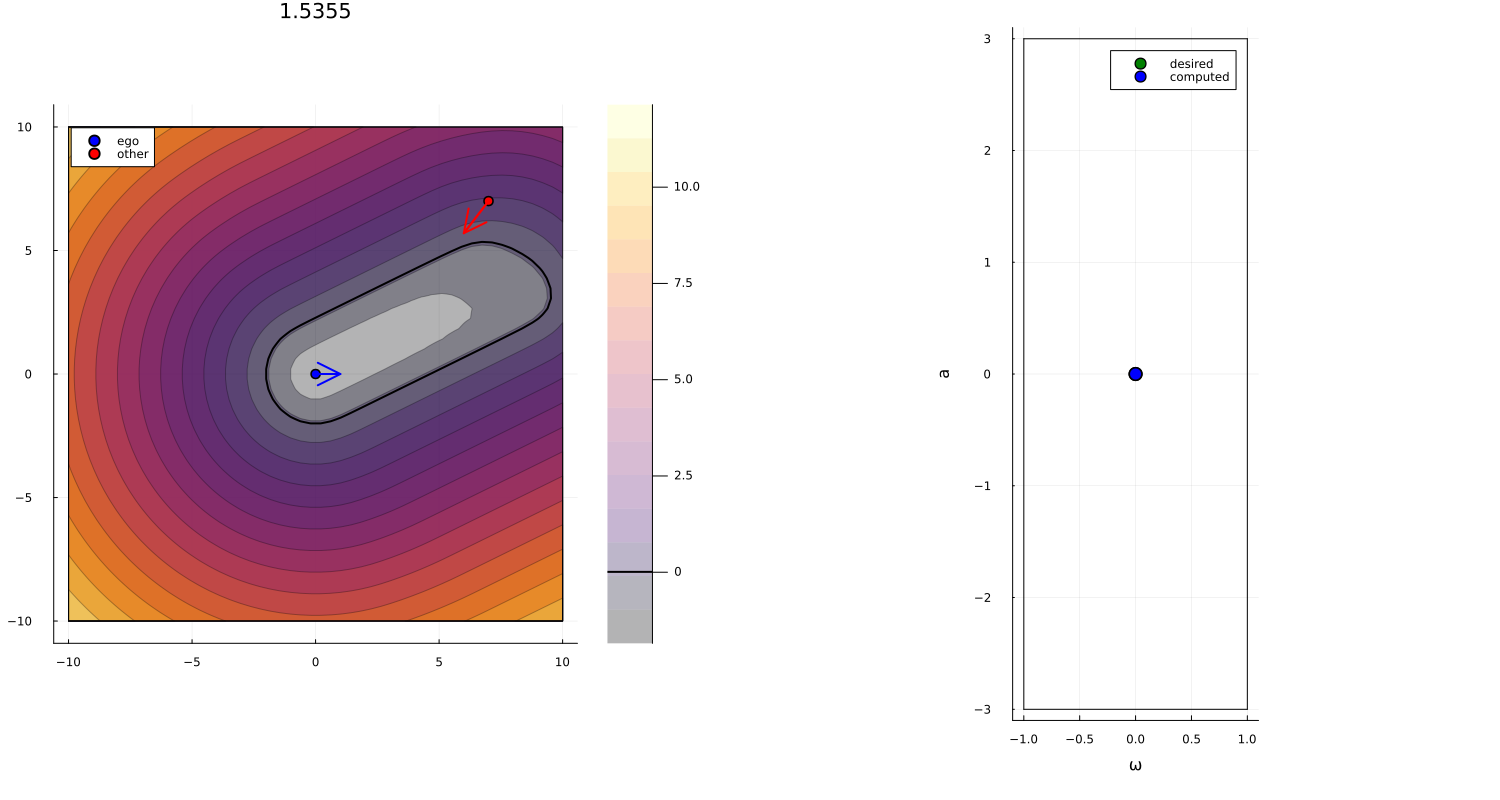

In [334]:
l = @layout [a b]

plot_value = plot(aspect_ratio=:equal, size=(1500,800), title="$(round(V_min, digits=4))", top_margin=-10mm, grid=true)
value_function = transpose(V.([grid_knots[1]], [grid_knots[2]], Ref(rel_state[3]), Ref(rel_state[4]), Ref(rel_state[5]))[1])
contourf!(plot_value, grid_knots[1], grid_knots[2], value_function, alpha=0.3)
contour!(plot_value, grid_knots[1], grid_knots[2], value_function, levels=[tol], linewidth=2, color=:black)
scatter!(plot_value, [0.], [0.], color=:blue, markersize=5, label="ego")
quiver!(plot_value, [0.], [0.], quiver=([rel_state[5]], [0]), linewidth=2, color=:blue)
scatter!(plot_value, [rel_state[1]], [rel_state[2]], color=:red, markersize=5, label="other")
quiver!(plot_value, [rel_state[1]], [rel_state[2]], quiver=([rel_state[4] * cos(rel_state[3])], [rel_state[4] * sin(rel_state[3])]), linewidth=2, color=:red)




lower = robot.control_min
upper = robot.control_max

plot_controls = plot(aspect_ratio=:equal, xlabel="ω", ylabel="a", xlim=(lower[1]-0.1, upper[1]+0.1), ylim=(lower[2]-0.1, upper[2]+0.1), bottom_margin=10mm, right_margin=5mm, top_margin=5mm)
c = dot(g, f0)
a = dot(g,B[:,1])
b = dot(g,B[:,2]) 
@show a, b, c

if V_min < tol
    if  (abs(b) > 1E-6) & (abs(a) > 1E-6)
        println("diagonal")
        y = [-c-a*lower[1], -c-a* upper[1]] / b
        if (b > 0)
            plot!(plot_controls, [lower[1],upper[1]], y, fillrange=[lower[2], lower[2]], fillalpha=0.6, color=:pink, label="")
        else
            plot!(plot_controls, [lower[1],upper[1]], y, fillrange=[upper[2], upper[2]], fillalpha=0.6, color=:pink, label="")
        end
    elseif (abs(b) < 1E-6) & (abs(a) > 1E-6)
        println("vertical")
        if a > 0  # u1 >= RHS
            x = min(-c/a, upper[1])
            vspan!(plot_controls, [lower[1], -c/a], alpha=0.6, color=:pink, label="unsafe")
            plot!(plot_controls, [-c/a, -c/a], [lower[2], upper[2]], label="")
        else # u1 <= RHS
            x = max(-c/a, lower[1])
            vspan!(plot_controls, [-c/a, upper[1]], alpha=0.6, color=:pink, label="unsafe")
            plot!(plot_controls, [-c/a, -c/a], [lower[2], upper[2]], label="")
        end
    elseif (abs(b) > 1E-6) & (abs(a) < 1E-6)
        println("horizontal")
        if b > 0
            plot!(plot_controls, [lower[1], upper[1]], [-c/b, -c/b], fillrange=[lower[2], lower[2]], fillalpha=0.6, color=:pink, label="")
        else
            plot!(plot_controls, [lower[1], upper[1]], [-c/b, -c/b], fillrange=[upper[2], upper[2]], fillalpha=0.6, color=:pink, label="")
        end
    end
end

plot!(plot_controls, [lower[1],upper[1]], [lower[2], lower[2]], color=:black, label="")
plot!(plot_controls, [upper[1],upper[1]], [lower[2], upper[2]], color=:black, label="")
plot!(plot_controls, [lower[1],upper[1]], [upper[2], upper[2]], color=:black, label="")
plot!(plot_controls, [lower[1],lower[1]], [lower[2], upper[2]], color=:black, label="")
scatter!(plot_controls, [desired_control[1]], [desired_control[2]], markersize=7, color=:green, label="desired")
scatter!(plot_controls, [u_out[1]], [u_out[2]], markersize=7, color=:blue, label="computed")

plot(plot_value, plot_controls, layout = l)